Calculating LTC


Start Alter (40)  40
End Alter (100)  100


Init pij
Init post
Init pre
Discount 0.9615
Discount 0.9615
x     40   P1  -166.92263    P2  -794.74079     Verh 476.11 %
x     41   P1  -174.31034    P2  -832.65067     Verh 477.68 %
x     42   P1  -182.01898    P2  -871.87063     Verh 479.00 %
x     43   P1  -190.05549    P2  -912.43054     Verh 480.09 %
x     44   P1  -198.44758    P2  -954.39065     Verh 480.93 %
x     45   P1  -207.21351    P2  -998.32055     Verh 481.78 %
x     46   P1  -216.35280    P2  -1045.36882     Verh 483.18 %
x     47   P1  -225.88358    P2  -1093.98394     Verh 484.31 %
x     48   P1  -235.82876    P2  -1143.88551     Verh 485.05 %
x     49   P1  -246.19773    P2  -1194.91200     Verh 485.35 %
x     50   P1  -257.02138    P2  -1247.20106     Verh 485.25 %
x     51   P1  -268.32542    P2  -1300.94200     Verh 484.84 %
x     52   P1  -280.11008    P2  -1355.99557     Verh 484.09 %
x     53   P1  -292.40827    P2  -1412.21686     Verh 482.96 %
x     54   P1  -305.26292    P2  -1469.33551     Verh 481.33 %
x

C:\Users\micha\AppData\Local\Temp\ipykernel_2920\2663492316.py:339: RuntimeWarning: invalid value encountered in double_scalars
  P_1 = pHandleBenefits.dGetDK(iStart,iStop,i,1) /  pHandlePrem.dGetDK(iStart,iStop,i,1) + 0.000001
C:\Users\micha\AppData\Local\Temp\ipykernel_2920\2663492316.py:341: RuntimeWarning: invalid value encountered in double_scalars
  P_2 = pHandleBenefits.dGetDK(iStart,iStop,i,2) /  pHandlePrem.dGetDK(iStart,iStop,i,2) + 0.000001


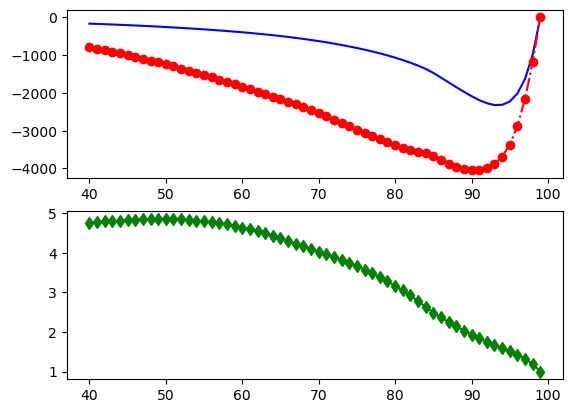

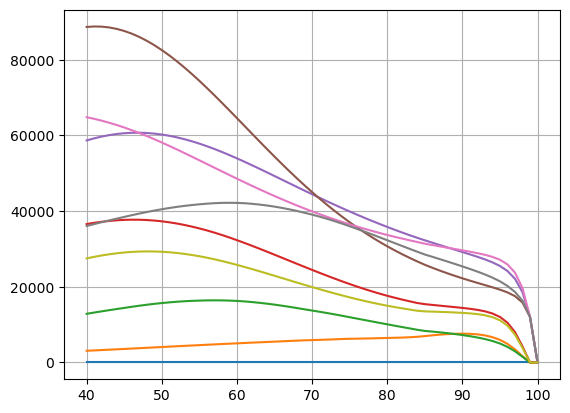

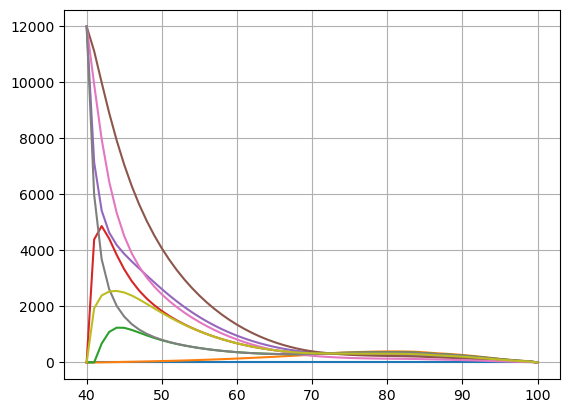

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)  
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscounT(self,fIRate):
        vTemp = 1./(1.+fIRate)
        print("Discount %.4f"%(vTemp))
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)

    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.0f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
                
            for j in range(self.iNrStates):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                plt.plot(x,y)
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)
        
            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
              for j in range(self.iNrStates):
                xBar.append(i+(j)*1./self.iNrStates)
                hBar.append(self.dGetCF(iStart,iStop,i,j))
                bBar.append(0)
                cBar.append(A[j])
            
            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./self.iNrStates,color=cBar)
            plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1


def read_array(filename, mylen):
    """ Read a file with an arbitrary number of columns.
        The type of data in each column is arbitrary
        It will be cast to the given dtype at runtime
    """
    return (np.loadtxt(filename))

print('Calculating LTC')
# ============================================================
iVon  = int(input("Start Alter (40) ")) 
iNach = int(input("End Alter (100) "))
iProduceAudit = 0
#symTex = open("test.tex","w")
# ============================================================
pij = read_array('pij.dat', 4)
post = read_array('post.dat', 4)
pre = read_array('pre.dat', 4)
PrePrem1 = read_array('PrePrem1.dat',4)
zins = read_array("zins.dat", 2)
# ============================================================
fid = open('MResult.dat','w');
pHandlePrem  = Markov()
pHandleBenefits  = Markov()
pHandlePrem.vDefineModel(9)
pHandleBenefits.vDefineModel(9)
# ============================================================
iStart = iNach
iStop = iVon
fInterstRate = 0.04
# ============================================================

print('Init pij')
for i in  range(pij.shape[0]):
    pHandlePrem.vSetPij(int(pij[i,0]), int(pij[i,1]),int(pij[i,2]), pij[i,3])
#    print "Pij  %d %d %d %10.4f" %(int(0.005+pij[i,0]), int(0.005+pij[i,1]-1),int(0.005+pij[i,2]-1), dTemp)
    pHandleBenefits.vSetPij(int(pij[i,0]), int(pij[i,1]),int(pij[i,2]), pij[i,3])
#    print "Pij2 %d %d %d %10.4f" % (int(0.005+pij[i,0]), int(0.005+pij[i,1]),int(0.005+pij[i,3]), pij[i,3])

print('Init post')

#for i in  range(post.shape[0]):
pHandlePrem.vSetPost(0,0,0,0)
pHandleBenefits.vSetPost(0,0,0,0)

print('Init pre')
for i in  range(0,101):
  for j in range(4,8):
      pHandleBenefits.vSetPre(i, j, j, 12000.)
#print "PRE %d %d  %d %10.4f" %(int(0.005+pre[i,0]), int(0.005+pre[i,1]-1),int(0.005+pre[i,2]-1), dTemp)

for i in  range(PrePrem1.shape[0]):
    pHandlePrem.vSetPre(int(PrePrem1[i,0]), int(PrePrem1[i,1]),int(PrePrem1[i,2]), PrePrem1[i,3])
#    print "PRE2 %d %10.4f" %(int(0.005+pre[i,0]), dTemp)

pHandlePrem.vSetDiscounT(fInterstRate)
pHandleBenefits.vSetDiscounT(fInterstRate)
#      print int(0.005+zins[i,0]), j,j, zins[i,1]
# ============================================================
values = np.zeros((100,4), dtype='f')
j= 0
for i in range(iVon, iNach+1):
    P_1 = pHandleBenefits.dGetDK(iStart,iStop,i,1) /  pHandlePrem.dGetDK(iStart,iStop,i,1) + 0.000001
#    print  i, pHandleBenefits.dGetDK(i,1,1), pHandlePrem.dGetDK(i,1,1), pHandleBenefits.dGetDK(i,4,1)
    P_2 = pHandleBenefits.dGetDK(iStart,iStop,i,2) /  pHandlePrem.dGetDK(iStart,iStop,i,2) + 0.000001
    strTemp = 'x  %5d   P1  %10.5f    P2  %10.5f     Verh %5.2f %%'%(i,P_1, P_2, 100 * P_2 / P_1)
    print(strTemp)
    fid.write(strTemp+"\n")
    values[j,0]=  i
    values[j,1]= P_1
    values[j,2]= P_2
    values[j,3]= P_2/P_1
    j = j + 1
#pHandleBenefits.vPrintTeX(symTex,True,"Test", True)
#symTex.close()

# ============================================================
valuesP = np.zeros((100,8), dtype='f') 
valuesB = np.zeros((100,8), dtype='f')
j2= 0
for i in range (iVon, 101):
  j2 = j2+1
  for k in range(8):
      
      valuesP[j2,k] = pHandlePrem.dGetDK(iStart,iStop,i,k) 
      valuesB[j2,k] = pHandleBenefits.dGetDK(iStart,iStop,i,k)

# ============================================================
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(values[0:j-1,0],values[0:j-1,1],'-b', values[0:j-1,0],values[0:j-1,2],'-.ro')
#Title('Absolute Premium for 12k / 6k')
plt.subplot(2,1,2)
plt.plot(values[0:j-1,0],values[0:j-1,3],'-dg')
#Title('Relative Premium P_2 / P_1')
fid.close()
# ============================================================

pHandleBenefits.PlotDKs(iStart,iStop,figNr=5)

pHandleBenefits.PlotCFs(iStart,iStop,figNr=6)

#pHandleBenefits.PlotDKDistr(iStart,iStop, iSteps = [iStop] , iStates = [0,1,2,3,4,5,6,7,8], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="LTC",default=0)


plt.show()
# ============================================================

**How to implement Waiting Perods?**

In the original model you have states 1,2,3,.. 7 repesenting the amount of DLA which you could do

- 1: you can do everything
- 2: 1 DLA is missing
- 3: 2 DLA are missing
- etc

For a waiting period of 2 years you would choose the following states

- instead of state 3 you would have states 3a, 3b, 3c, where you are in a at the beginning, in b after b after a year and later on in c
- you pay onlz in state 3c
- ditto for the other higher states

Transition prob

- pij (i,j) with i = n(A,B,C) to j = m(A,B,C) as follows

pij (i,j) = pij(n,m)